# Supervised ML Classifiers for Tanzanian Water-Wells Condition

- **Student  :** Daniel Mwaka
- **Student Pace  :** DSF-FT12
- **Phase :** 3
- **Instructor Name  :** Samuel Karu

## 1 Introduction

Access to clean and reliable water is a fundamental human right and a cornerstone of sustainable development. In many developing nations, including Tanzania, ensuring this access remains a significant challenge. While numerous water points have been established, a substantial portion are in disrepair or have ceased to function altogether, leaving millions without consistent access to this vital resource. The ability to proactively identify and address the issues plaguing these water wells is not just an operational necessity but a critical step towards improving public health, economic stability, and overall quality of life for communities. Understanding the factors that contribute to the failure or disrepair of water infrastructure is therefore paramount, enabling targeted interventions and more effective resource allocation.

This project utilizes three datasets (**trainingset.csv**, **trainingsetlabels.csv**, and **testdata.csv**). 

The datasets are available on https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/.

Utilizing these datasets, the project:

- Identifies potential predictor features in the **trainingset.csv** dataset on a water-well's respective status as captured for each record entry in the **trainingsetlabels.csv** dataset.
- Builds, and tunes three supervised ML classifier models to predict the condition of water wells (`functional`, `functional needs repair`, or `non functional`).
- Evaluates the performance metrics (**accuracy**, **precision**, **recall**, **f1-score**, and **ROC_AUC**) of the three ML classifiers to select the best-fit, and most-generalizable model.
- Utilizes the selected model to predict the target variable for 14,850 record entries in **testdata.csv** dataset. 
- Recommends the selected model for deployment, and proposed next steps to stakeholders.

### 1.1 Problem Statement

The Government of Tanzania and Non-Governmental Organizations (NGOs) face a significant challenge in ensuring reliable access to clean water for their population. A substantial number of established water wells are either in disrepair or have completely failed, leading to water scarcity and its associated negative impacts on public health and socio-economic development. There is currently no effective, data-driven method to accurately predict the condition of water wells, making it difficult to prioritize repair efforts, allocate resources efficiently, and inform the design of new, more resilient water infrastructure. This lack of predictive capability results in reactive maintenance, inefficient resource utilization, and continued widespread water scarcity. The Government of Tanzania and NGOs require a solution that can identify water wells that are in need of repair or are likely to fail, enabling proactive interventions and strategic planning for a sustainable water supply.

### 1.2 Objectives

#### 1.2.1 Goal
To recommend an evidence-based supervised ML classification model for predicting the functional condition of water wells in tanzania.

#### 1.2.2 Specific Objectives
1. Preprocess available datasets to justify the predictive power of  features on the target variable.

2. Build, tune, and evaluate the performance of a baseline model, a tree-based classifier, and an ensemble ML model.

3. Compare performance metrics of the three classifiers to propose the best alternative for deployment. 

4. Validate the performance of the selected model in predicting the target variable using feature data in **testdata.csv**.

5. Recommend feasible recommendations to stakeholders and propose viable next steps.


## 2 Exploratory Data Analysis (EDA)
### 2.1 Data Loading 

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [2]:
# Load training datasets
train_features = pd.read_csv("./data/trainingset.csv")
train_labels = pd.read_csv("./data/trainingsetlabels.csv")

# Merge features and labels for EDA
train_df = pd.merge(train_features, train_labels, on="id")

# Display first five rows
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [3]:
# Inspect column attributes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### 2.2 Data Preprocessing
A modularized preprocessing pipeline is adopted to avoid data leakage.
#### 2.2.1 Define Exog and Endog

In [4]:
# Identify numerical and categorical columns
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('id')
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('status_group')

# Define exogenous (X) and endogenous (y) variables
X = train_df[num_cols + cat_cols]
y = train_df['status_group']

#### 2.2.2 Perform Train-Test Split

In [5]:
# Separate data into a train set and a test set before performing any preprocessing steps
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape : {X_train.shape}")
print(f"X_test shape  : {X_test.shape}")

X_train shape : (47520, 39)
X_test shape  : (11880, 39)


#### 2.2.3 Drop Rendundant and Irrelevant Columns

- The following columns contain redundant information for each entry.

| Picked Column | Redundant Column 1 | Redundant Column 2 |
|----------|----------|----------|
| extraction_type_class | extraction_type | extraction_type_group |
| management_group | scheme_management | management | 
| payment_type | payment |  | 
| water_quality | quality_group | | 
| quantity | quantity_group |  |  
| source_type | source | source_class |  
| waterpoint_type_group | waterpoint_type |  | 

The columns deemed relevant from the training dataset with respect to the scope of this project include:

| Column Name | Data Type | Short Description |
|----------|----------| -------- |
| date_recorded | object | The Year, Month, and Date an entry was recorded (yyyy-mm-dd)  |
| gps_height | int64 | The altitude of the water well location in meters  |
| basin | object | The geographical basin where the water well is located |
| region | object | The administrative region where the water well is situated |
| population | int64 | The population size served/ used to be served by a water well |
| permit | object | Whether the water well has a legal permit |
| construction_year | int64 | The year the water well was constructed |
| extraction_type_class | object  | The method/ technology used to extract water |
| management_group | object | The group responsible for managing the water well |
| payment_type | object | The payment policy for using the water well |
| water_quality | object | The quality of the water from the well |
| quantity | object | The amount of water available from the well |
| source_type | object | The type of water source |
| waterpoint_type_group | object | The infrustructure used to access water from the well point |

In [6]:
# Create a copy of X_train
X_train_1 = X_train.copy()

# Select relevant columns w.r.t to project scope
picked_cols = [
    'date_recorded',
    'gps_height',
    'basin',
    'region',
    'population',
    'permit',
    'construction_year',
    'management_group', 
    'extraction_type_class', 
    'payment_type', 
    'water_quality', 
    'quantity', 
    'source_type', 
    'waterpoint_type'
]
# Reassign X_train with selected columns 
X_train_1 = X_train_1.loc[:, picked_cols]
X_train_1.head()

,date_recorded,gps_height,basin,region,population,permit,construction_year,management_group,extraction_type_class,payment_type,water_quality,quantity,source_type,waterpoint_type
43360,2011-07-27,0,Lake Nyasa,Mbeya,0,NaN,0,user-group,gravity,never pay,soft,insufficient,spring,communal standpipe
7263,2011-03-23,2049,Rufiji,Iringa,175,True,2008,user-group,gravity,monthly,soft,enough,spring,communal standpipe
2486,2011-03-07,290,Wami / Ruvu,Pwani,2300,False,2010,user-group,handpump,per bucket,salty,insufficient,shallow well,hand pump
313,2011-07-31,0,Lake Victoria,Kagera,0,True,0,user-group,other,never pay,soft,enough,shallow well,other
52726,2011-03-10,0,Internal,Dodoma,0,True,0,user-group,motorpump,per bucket,soft,enough,borehole,communal standpipe


#### 2.2.4 Handle Missing Values

In [7]:
# Check for missing values
X_train_1.isna().sum()

date_recorded               0
gps_height                  0
basin                       0
region                      0
population                  0
permit                   2443
construction_year           0
management_group            0
extraction_type_class       0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
dtype: int64

In [8]:
# Check unique values for the `permit` feature
X_train_1['permit'].unique()

array([nan, True, False], dtype=object)

- Only one of the features (`permit`) has missing values. The feature is boolean since entries for water-wells with a permit are assigned **True** and those without a permit are assigned **False**. Thus, **nans** in the `permit` column represent missing values.

In [9]:
# Calculate percentage of missing values for the 'permit' column
X_train_1['permit'].isna().mean() * 100

np.float64(5.1409932659932664)

X_train_1 has 47,520 rows and entries with nan values for the `permit` column account for 5.14%. Hence, dropping all entries with missing values for the `permit` feature won't have a significant impact on the size of the training set.

In [10]:
X_train_1 = X_train_1.dropna(subset=['permit'])

In [11]:
# Recheck X_train shape
X_train_1.shape
print(f"Training dataset consists of: {X_train_1.shape[0]} rows")
print(f"Training dataset consists of: {X_train_1.shape[1]} columns")

Training dataset consists of: 45077 rows
Training dataset consists of: 14 columns


#### 2.2.5 Feature Engineering

A well's age is an important predictor on it condition. Although the feature is not included in the training.csv dataset; it can be engineered by convering the `date_recorded` variable to datetime and substracting the value from a water-well's `construction_year`.

In [12]:
# Check unique values for `construction_year` feature
X_train_1['construction_year'].unique()

array([2008, 2010,    0, 1986, 1995, 1985, 2009, 2001, 1972, 2003, 2006,
       1994, 1996, 1980, 1979, 2005, 1990, 2007, 2004, 1978, 1977, 1991,
       1999, 1993, 1983, 1997, 2011, 1989, 1998, 2000, 1984, 1982, 1992,
       2012, 1975, 1976, 2002, 1970, 1963, 1968, 1981, 1988, 1987, 2013,
       1973, 1971, 1961, 1974, 1962, 1969, 1960, 1964, 1967, 1966, 1965])

In [13]:
# Drop all row entries with a value of 0 in the column `construction_year`
X_train_1.drop(X_train_1[X_train_1['construction_year'] == 0].index, inplace=True)

In [14]:
# Recheck X_train shape
X_train_1.shape
print(f"Training dataset consists of: {X_train_1.shape[0]} rows")
print(f"Training dataset consists of: {X_train_1.shape[1]} columns")

Training dataset consists of: 29464 rows
Training dataset consists of: 14 columns


In [15]:
# Convert 'date_recorded' to datetime year
X_train_1['date_recorded'] = pd.to_datetime(X_train_1['date_recorded']).dt.year

# Calculate well_age = date_recorded - construction_year
X_train_1['well_age'] = X_train_1['date_recorded'] - X_train_1['construction_year']

In [16]:
# Confirm the Engineered feature accurately captures a well's age 
X_train_1[['date_recorded', 'construction_year', 'well_age']].head()

,date_recorded,construction_year,well_age
7263,2011,2008,3
2486,2011,2010,1
8558,2011,1986,25
2559,2013,1995,18
28603,2013,1985,28


In [17]:
 # Drop 'construction_year' and 'date_recorded' features from X_train
X_train_1 = X_train_1.drop(columns=['construction_year', 'date_recorded'])

In [18]:
# Check descriptive statistics for the engineered `well-age` feature
X_train_1['well_age'].describe()

count    29464.000000
mean        15.235643
std         12.502163
min         -7.000000
25%          4.000000
50%         12.000000
75%         25.000000
max         53.000000
Name: well_age, dtype: float64

- It is impossible for the age of a water-well to be a negative number. The computed negative well-age value is likely due to either an error in an entry's `date_recorded` or `construction_year` columns. 

In [19]:
# Drop all row entries whose values for 'well_age' are less than zero
X_train_1 = X_train_1[X_train_1['well_age'] >= 0]

In [20]:
# Recheck X_train shape
X_train_1.shape
print(f"Training dataset consists of: {X_train_1.shape[0]} rows")
print(f"Training dataset consists of: {X_train_1.shape[1]} columns")

Training dataset consists of: 29455 rows
Training dataset consists of: 13 columns


In [21]:
# Print first-five rows after feature engineering
X_train_1.head()

,gps_height,basin,region,population,permit,management_group,extraction_type_class,payment_type,water_quality,quantity,source_type,waterpoint_type,well_age
7263,2049,Rufiji,Iringa,175,True,user-group,gravity,monthly,soft,enough,spring,communal standpipe,3
2486,290,Wami / Ruvu,Pwani,2300,False,user-group,handpump,per bucket,salty,insufficient,shallow well,hand pump,1
8558,1295,Lake Tanganyika,Rukwa,200,True,user-group,gravity,never pay,soft,insufficient,river/lake,communal standpipe,25
2559,1515,Pangani,Arusha,150,True,user-group,gravity,monthly,soft,insufficient,spring,communal standpipe multiple,18
28603,286,Ruvuma / Southern Coast,Mtwara,1,True,user-group,other,unknown,salty,dry,shallow well,other,28


#### 2.2.6 Multicollinearity Check

- Highly correlated numerical features leads to multicolinearity. Training supervised ML classifiers with highly correlated numerical features increases computational complexity, and elevates the risk for overfitting. 
- Additionally, multicollinearity leads to uncertainity in determining the true contribuction of each feature to predictions.
- Correlation measures are highly sensitive to outliers. Thus, plotting a correlation matrix for the numerical features in X_train will shed insights on highly correlated variables.

In [22]:
# Identify numerical columns after engineering features
X_train_num_cols = X_train_1.select_dtypes(include=[np.number]).columns.tolist()

# Remove outliers
for col in X_train_num_cols:
    lower = X_train_1[col].quantile(0.01)
    upper = X_train_1[col].quantile(0.99)
    X_train_1 = X_train_1[(X_train_1[col] >= lower) & (X_train_1[col] <= upper)]


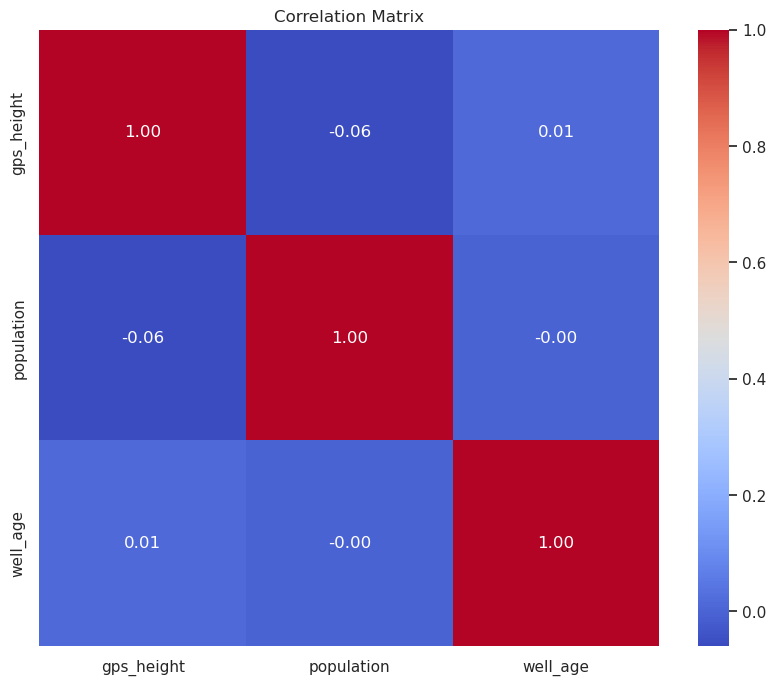

In [23]:
# Plot the correlation matrix
corr = X_train_1[X_train_num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- There is no multicolineariry among the three numerical variables. 
- For the inclusion of the three numerical variables in the features' matrix, they must normalized. 
- The MinMaxScaller is selected because it scales numerical features between 0 and 1. Hence, the scaled numerical features will lie within the same range as the OneHotEncoded dummy variables for categorical features. 

#### 2.2.7 Normalize Numerical Features and One Hot Encode Categorical Features

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Create a copy of the training set
X_train_scaled = X_train_1.copy()

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# fit_transform the numerical columns using MinMaxScaler to normalize the data
X_train_scaled[X_train_num_cols] = scaler.fit_transform(X_train_scaled[X_train_num_cols])
X_train_num_df = pd.DataFrame(X_train_scaled, columns=X_train_num_cols, index=X_train_scaled.index)
X_train_num_df.head()

,gps_height,population,well_age
7263,0.941897,0.0700,0.068182
2486,0.143441,0.9200,0.022727
8558,0.599637,0.0800,0.568182
2559,0.699501,0.0600,0.409091
28603,0.141625,0.0004,0.636364


In [25]:
# Identify categorical columns in X_train_scaled
X_train_cat_cols = X_train_scaled.select_dtypes(include=['object']).columns.tolist()
print(X_train_cat_cols)

['basin', 'region', 'permit', 'management_group', 'extraction_type_class', 'payment_type', 'water_quality', 'quantity', 'source_type', 'waterpoint_type']


In [26]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit and transform X_train_scaled categorical columns
X_train_ohe = ohe.fit_transform(X_train_scaled[X_train_cat_cols])

# Convert to DataFrame for easier inspection
ohe_feature_names = ohe.get_feature_names_out(X_train_cat_cols)
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_feature_names, index=X_train_scaled.index)

In [27]:
# Concat the normalized numerical features df and the OneHot encoded categorical features df
X_train_final = pd.concat([X_train_num_df, X_train_ohe_df], axis=1)

# Print first five rows of concatenated df
X_train_final.head()

,gps_height,population,well_age,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
7263,0.941897,0.0700,0.068182,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2486,0.143441,0.9200,0.022727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8558,0.599637,0.0800,0.568182,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2559,0.699501,0.0600,0.409091,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
28603,0.141625,0.0004,0.636364,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# Check X_train_final shape
X_train_final.shape
print(f"Training dataset consists of: {X_train_final.shape[0]} rows")
print(f"Training dataset consists of: {X_train_final.shape[1]} columns")

Training dataset consists of: 28346 rows
Training dataset consists of: 67 columns


#### 2.2.8 Label Encode Target Variable

In [29]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of y_train
y_train_1 = y_train.copy()

# Align y_train to X_train_final indices 
y_train_aligned = y_train_1.loc[X_train_final.index]

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform y_train_aligned using LabelEncoder
y_train_enc = le.fit_transform(y_train_aligned)

# Print class distribution of the encoded y_train labels
print(f"Encoded y_train distribution: {np.bincount(y_train_enc)}")

Encoded y_train distribution: [16007  1856 10483]


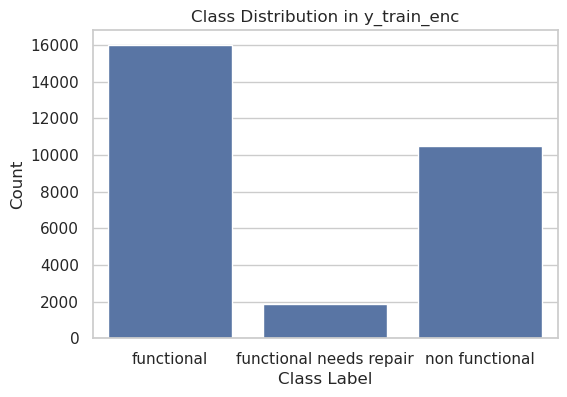

In [30]:
# Visualize class distributions in y_train_enc
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_enc)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in y_train_enc')
plt.xticks(ticks=[0,1,2], labels=le.classes_)
plt.show()

It is evident the target variable has class imbalance.

- `functional` = 16,007 samples
- `functional needs repair` = 1,856 samples
- `non functional` = 10,483 samples

Training ML classifiers on an unbalanced data can result to a biased model that performs exceptionally well in making predictions for the majority class but poorly for the minority classes. Additionally, it compromises the legibility of standard evaluation measures when comparing the performance of different models to determine the best fit/ most appropriate alternative respective to a specific business problem. For instance, the accuracy metrics can be deceptive since a model's score is skewed upwards if it is able to make accurate predictions for the majority class even if it performs poorly in predicting the minority class. 

#### 2.2.9 Addressing Class Imbalance

The undersampling approach is adopted to address the class imbalance in the target variable for the training set. The technique involves randomly reducing the number of samples in the majority classes to match the number of samples in the minority class. The rationale for adopting the undersampling technique is as follows:

- **Improved Model Generalization:** By balancing the class distribution, the model is encouraged to learn patterns for all classes, not just the majority, leading to better generalization and fairer predictions.
- **Reliable Evaluation Metrics:** Balanced classes ensure that evaluation metrics (such as accuracy, precision, recall, and F1-score) more accurately reflect the model's performance across all classes, rather than being dominated by the majority class.
- **Simplicity and Data Integrity:** Given that the minority class is not extremely small, undersampling avoids the risk of overfitting associated with oversampling techniques (like SMOTE) and maintains the authenticity of the data.


In [31]:
from sklearn.utils import resample

# Combine X_train_final and y_train_enc into a DataFrame for resampling
Xy_train = X_train_final.copy()
Xy_train['target'] = y_train_enc

# Find the minority class count
min_class_count = Xy_train['target'].value_counts().min()

# Separate each class
class_0 = Xy_train[Xy_train['target'] == 0]
class_1 = Xy_train[Xy_train['target'] == 1]
class_2 = Xy_train[Xy_train['target'] == 2]

# Downsample majority classes to match the minority class
class_0_down = resample(class_0, replace=False, n_samples=min_class_count, random_state=42)
class_2_down = resample(class_2, replace=False, n_samples=min_class_count, random_state=42)

# Combine all classes
Xy_balanced = pd.concat([class_0_down, class_1, class_2_down])
Xy_balanced = Xy_balanced.sample(frac=1, random_state=42)  # Shuffle

# Split back into features and target
X_train_balanced = Xy_balanced.drop('target', axis=1)
y_train_balanced = Xy_balanced['target']

print("Class distribution of y_train_balanced after undersampling:")
print(y_train_balanced.value_counts())
print("------------------------------------------------------------------------")

# Check X_train_balanced shape
X_train_balanced.shape
print(f"X_train_balanced consists of: {X_train_balanced.shape[0]} rows")
print(f"X_train_balanced consists of: {X_train_balanced.shape[1]} columns")

Class distribution of y_train_balanced after undersampling:
target
0    1856
2    1856
1    1856
Name: count, dtype: int64
------------------------------------------------------------------------
X_train_balanced consists of: 5568 rows
X_train_balanced consists of: 67 columns


In [32]:
# Display first five rows to verify numerical features are standardized and categorical features OneHot encoded
X_train_balanced.head()

,gps_height,population,well_age,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
46891,0.719473,0.0988,0.318182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10203,0.144349,0.0800,0.181818,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18286,0.679528,0.2120,0.750000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31129,0.445756,0.0800,0.750000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
34268,0.067181,0.1368,0.136364,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 2.3 Preprocess Test Data

In [33]:
# Select relevant columns for the test set 
X_test = X_test.loc[:, picked_cols]

# Create a copy of X_test
X_test_1 = X_test.copy()

# Drop entries with nans in the `permit` feature
X_test_1 = X_test_1.dropna(subset=['permit'])

# Enginner well_age features, and drop entries whose well age is less than 0
X_test_1.drop(X_test_1[X_test_1['construction_year'] == 0].index, inplace=True)
X_test_1['date_recorded'] = pd.to_datetime(X_test_1['date_recorded']).dt.year
X_test_1['well_age'] = X_test_1['date_recorded'] - X_test_1['construction_year']
X_test_1 = X_test_1.drop(columns=['construction_year', 'date_recorded'])
X_test_1 = X_test_1[X_test_1['well_age'] >= 0]

# Identify numerical features and categorical features 
X_test_num_cols = X_test_1.select_dtypes(include=[np.number]).columns.tolist()
X_test_cat_cols = X_test_1.select_dtypes(include=['object']).columns.tolist()

# Remove outliers across numerical features 
for col in X_test_num_cols:
    lower = X_test_1[col].quantile(0.01)
    upper = X_test_1[col].quantile(0.99)
    X_test_1 = X_test_1[(X_test_1[col] >= lower) & (X_test_1[col] <= upper)]

# Normalize numerical features in test set
X_test_scaled = X_test_1.copy()
X_test_scaled[X_test_num_cols] = scaler.transform(X_test_scaled[X_test_num_cols])
X_test_num_df = pd.DataFrame(X_test_scaled, columns=X_test_num_cols, index=X_test_scaled.index)

# OneHot Encode categorical features in test set
X_test_ohe = ohe.transform(X_test_scaled[X_test_cat_cols])
ohe_feature_names = ohe.get_feature_names_out(X_test_cat_cols)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_feature_names, index=X_test_scaled.index)

# Concat normalized numerical features and OneHot encoded categorical features
X_test_final = pd.concat([X_test_num_df, X_test_ohe_df], axis=1)

# Get the indices present in X_test_final and filter y_test to only those indices
test_indices = X_test_final.index
y_test_aligned = y_test.loc[test_indices]

# Label Encode the target variable of filtered y_test
y_test_enc = le.transform(y_test_aligned)

In [34]:
# Print the distribuction of y_test_enc
print(f"Encoded y_test distribution: {np.bincount(y_test_enc)}")
print("----------------------------------------------")
# Check X_test_final shape
X_test_final.shape
print(f"X_test_final consists of: {X_test_final.shape[0]} rows")
print(f"X_test_final  consists of: {X_test_final.shape[1]} columns")

Encoded y_test distribution: [3919  464 2636]
----------------------------------------------
X_test_final consists of: 7019 rows
X_test_final  consists of: 67 columns


In [35]:
# Display first five rows to verify numerical features are standardized and categorical features OneHot encoded
X_test_final.head()

,gps_height,population,well_age,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
47666,0.727190,0.0004,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
51817,0.260554,0.2000,0.590909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21378,0.825692,0.0000,0.340909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
14334,0.573763,0.0260,0.568182,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8314,0.020881,0.0600,0.068182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Export preprocessed training data as a CSV file
export_train_df = X_train_balanced.copy()
export_train_df['status_group'] = le.inverse_transform(y_train_balanced)
export_train_df.to_csv('./data/preprocessed-train-set.csv', index=False)

## 3 Modelling 

### 3.1 Logistic Regression Model

Build a simple supervised classification model (Logistic Regression), evaluate its performance, and discuss its limitations. The simple model is tuned to re-evaluate performance before proceeding on to build alternative classification models.

#### 3.1.1 Untuned Logistic Regression Model

In [37]:
# Fit Logistic Regression Model on Preprocessed and Balanced Data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [38]:
# Predict on Train and Test Sets (using preprocessed data)
y_pred_train = logreg.predict(X_train_balanced)
y_proba_train = logreg.predict_proba(X_train_balanced)
y_pred_test = logreg.predict(X_test_final)
y_proba_test = logreg.predict_proba(X_test_final)

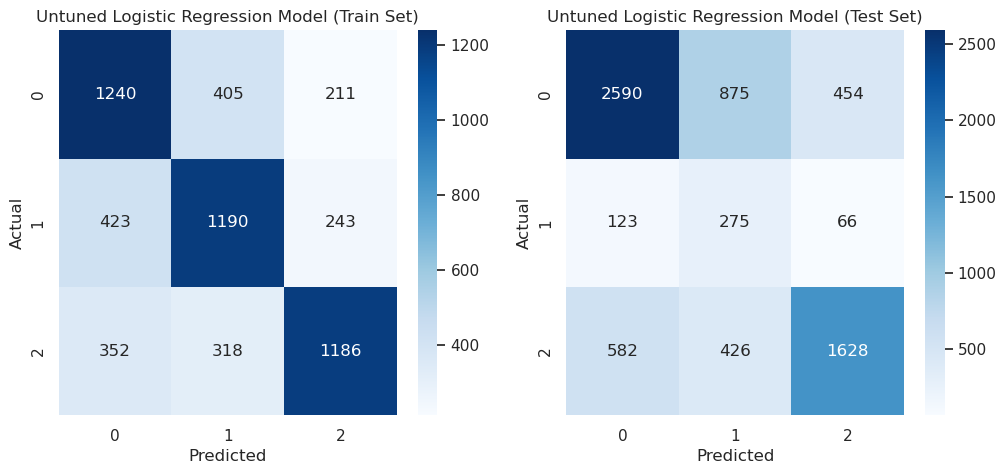

In [39]:
# Plot confusion matrices for logistic regression model on both train and test sets (using correct y labels)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_train = confusion_matrix(y_train_balanced, y_pred_train)
cm_test = confusion_matrix(y_test_enc, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Untuned Logistic Regression Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Untuned Logistic Regression Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-untuned-logistic-regression-model.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

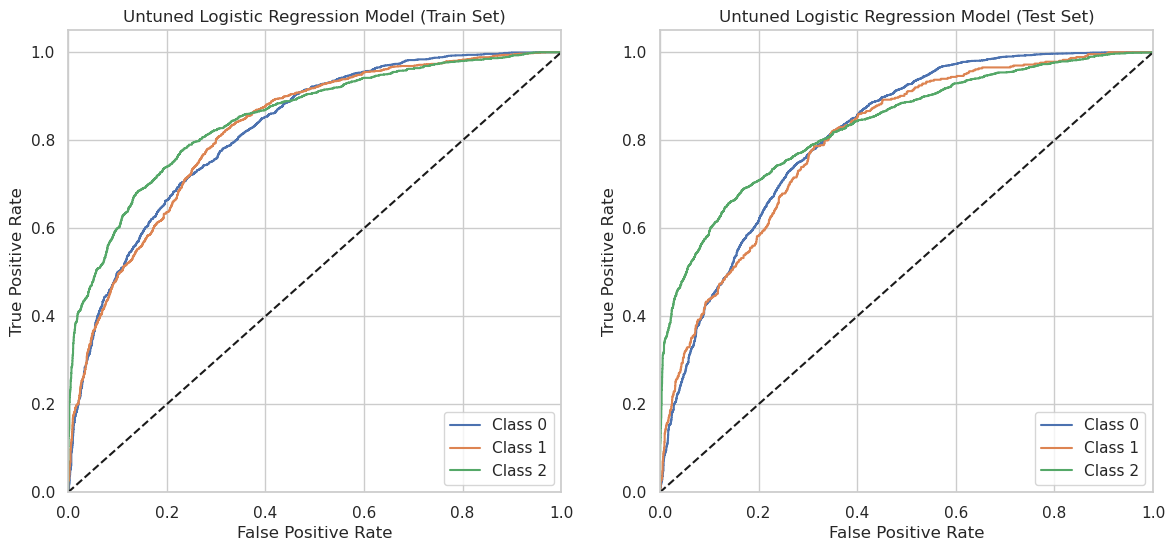

In [40]:
# Plot ROC curves for logistic regression model on both train and test sets (using correct y labels)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
import numpy as np

n_classes = len(np.unique(y_train_balanced))
y_train_bin = label_binarize(y_train_balanced, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Untuned Logistic Regression Model (Train Set)')
axes[0].legend(loc='lower right')
axes[0].grid(True)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Untuned Logistic Regression Model (Test Set)')
axes[1].legend(loc='lower right')
axes[1].grid(True)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.savefig("./images/roc-curves-untuned-logistic-regression-model.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

#### 3.1.2 Tuned Logistic Regression Model

In [41]:
# Hyperparameter tuning for Logistic Regression (Tuned Model)
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_train_balanced, y_train_balanced)
print(f"Best parameters: {gs.best_params_}")

Best parameters: {'C': 10}


In [42]:
# Predict on train and test sets (using preprocessed data)
y_pred_gs_train = gs.predict(X_train_balanced)
y_proba_gs_train = gs.predict_proba(X_train_balanced)
y_pred_gs = gs.predict(X_test_final)
y_proba_gs = gs.predict_proba(X_test_final)

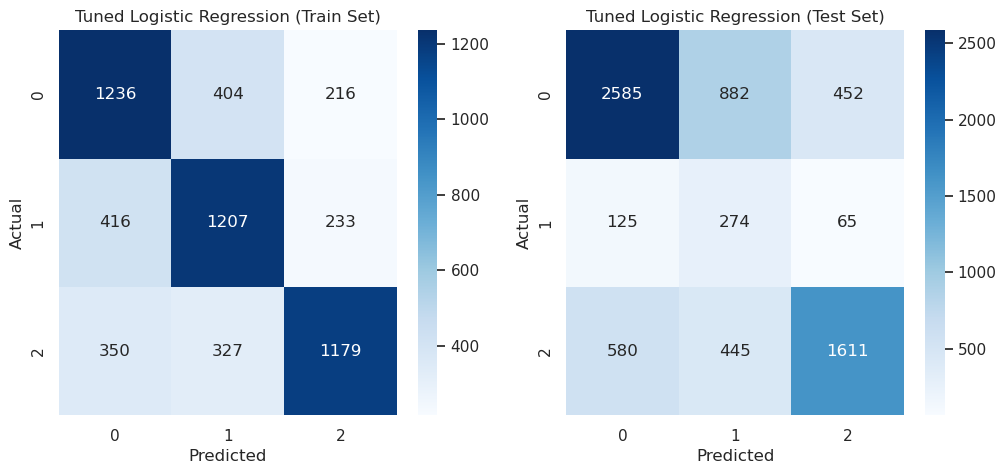

In [43]:
# Plot confusion matrices for logistic regression model on both train and test sets (using correct y labels)
cm_train = confusion_matrix(y_train_balanced, y_pred_gs_train)
cm_test = confusion_matrix(y_test_enc, y_pred_gs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Tuned Logistic Regression (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Tuned Logistic Regression (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-tuned-logistic-regression-model.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

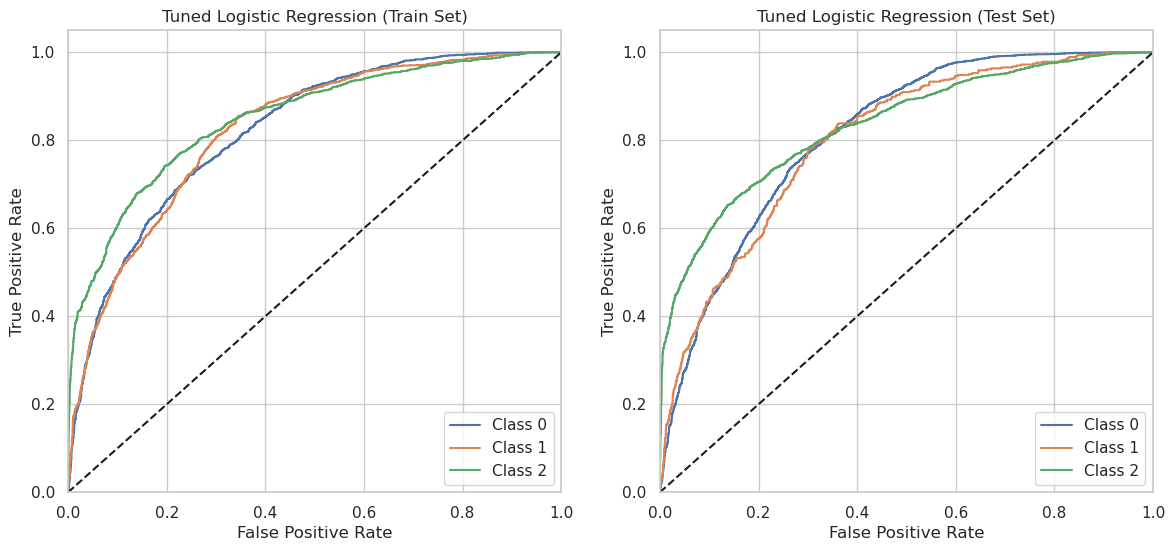

In [44]:
# Plot ROC curves for tuned logistic regression model on both train and test sets (using correct y labels)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
import numpy as np

n_classes = len(np.unique(y_train_balanced))
y_train_bin = label_binarize(y_train_balanced, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tuned Logistic Regression (Train Set)')
axes[0].legend(loc='lower right')
axes[0].grid(True)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Tuned Logistic Regression (Test Set)')
axes[1].legend(loc='lower right')
axes[1].grid(True)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.savefig("./images/roc-curves-tuned-logistic-regression-model.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [45]:
# Evaluate performance on train and test set for untuned logistic regression model
acc_train = accuracy_score(y_train_balanced, y_pred_train)
prec_train = precision_score(y_train_balanced, y_pred_train, average='weighted')
rec_train = recall_score(y_train_balanced, y_pred_train, average='weighted')
f1_train = f1_score(y_train_balanced, y_pred_train, average='weighted')
roc_auc_train = roc_auc_score(y_train_balanced, y_proba_train, multi_class='ovr')

acc_test = accuracy_score(y_test_enc, y_pred_test)
prec_test = precision_score(y_test_enc, y_pred_test, average='weighted')
rec_test = recall_score(y_test_enc, y_pred_test, average='weighted')
f1_test = f1_score(y_test_enc, y_pred_test, average='weighted')
roc_auc_test = roc_auc_score(y_test_enc, y_proba_test, multi_class='ovr')

# Evaluate performance on train and test set for tuned logistic regression model
gs_train_preds = y_pred_gs_train
gs_train_proba = y_proba_gs_train
gs_test_preds = y_pred_gs
gs_test_proba = y_proba_gs

acc_gs_train = accuracy_score(y_train_balanced, gs_train_preds)
prec_gs_train = precision_score(y_train_balanced, gs_train_preds, average='weighted')
rec_gs_train = recall_score(y_train_balanced, gs_train_preds, average='weighted')
f1_gs_train = f1_score(y_train_balanced, gs_train_preds, average='weighted')
roc_auc_gs_train = roc_auc_score(y_train_balanced, gs_train_proba, multi_class='ovr')

acc_gs = accuracy_score(y_test_enc, gs_test_preds)
prec_gs = precision_score(y_test_enc, gs_test_preds, average='weighted')
rec_gs = recall_score(y_test_enc, gs_test_preds, average='weighted')
f1_gs = f1_score(y_test_enc, gs_test_preds, average='weighted')
roc_auc_gs = roc_auc_score(y_test_enc, gs_test_proba, multi_class='ovr')

# Create a DataFrame with metrics for both untuned and tuned Logistic Regression
metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_train, acc_gs_train],
    'Test Accuracy': [acc_test, acc_gs],
    'Train Precision': [prec_train, prec_gs_train],
    'Test Precision': [prec_test, prec_gs],
    'Train Recall': [rec_train, rec_gs_train],
    'Test Recall': [rec_test, rec_gs],
    'Train F1-score': [f1_train, f1_gs_train],
    'Test F1-score': [f1_test, f1_gs],
    'Train ROC-AUC': [roc_auc_train, roc_auc_gs_train],
    'Test ROC-AUC': [roc_auc_test, roc_auc_gs]
})

metrics_df.set_index('Model', inplace=True)
metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.649425,0.640120,0.653538,0.735050,0.649425,0.640120,0.650206,0.674341,0.831456,0.816311
Tuned Model,0.650503,0.636843,0.654797,0.734322,0.650503,0.636843,0.651274,0.671957,0.832015,0.816505


#### 3.1.3 Model Performance Comparison: Untuned vs. Tuned Logistic Regression

- The untuned Logistic Regression model achieved an F1-score of approximately 0.65 (train) and 0.67 (test) with an accuracy of about 65% on both sets. The ROC-AUC score is about 83% (train) and 82% (test).
- After hyperparameter tuning, the tuned Logistic Regression model neither registered significant improvement on f1-score nor accuracy. Additionally, the tuned model did not achive discernable improvement in ROC-AUC scores on both the training and test sets. 

**Limitation:** Logistic Regression is limited in capturing interactions between features when fitting complex datasets since its approach framework tries to separate classes using hyperplanes. To address these limitations, it is necessary to build a Decision Tree Classifier model. Tree-based classifiers can model non-linear relationships and feature interactions more effectively, potentially improving classification performance. 

### 3.2 Tree-Based Classification Model

A Decision Tree Classifier is a supervised machine learning algorithm used for classification tasks. It works by recursively splitting the dataset into subsets based on the value of input features, forming a tree-like structure of decisions. Each internal node represents a decision based on a feature, each branch represents the outcome of that decision, and each leaf node represents a class label (prediction).

Decision Trees can capture non-linear relationships and interactions between features without requiring explicit feature engineering. They can model complex decision boundaries by splitting the data multiple times based on different features and thresholds. This flexibility allows Decision Trees to potentially achieve better predictive performance than Logistic Regression, especially when the underlying patterns in the data are not well-approximated by linear models. Hence, Decision Tree Classifiers have substantial potential to outperform the Logistic Regression model in a ternary classification problem.

#### 3.2.1 Untuned Decision Tree Classifier

In [46]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42, criterion='gini')
dt.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(random_state=42)

In [47]:
# Predict for train and test set
y_pred_dt_train = dt.predict(X_train_balanced)
y_proba_dt_train = dt.predict_proba(X_train_balanced)
y_pred_dt_test = dt.predict(X_test_final)
y_proba_dt_test = dt.predict_proba(X_test_final)

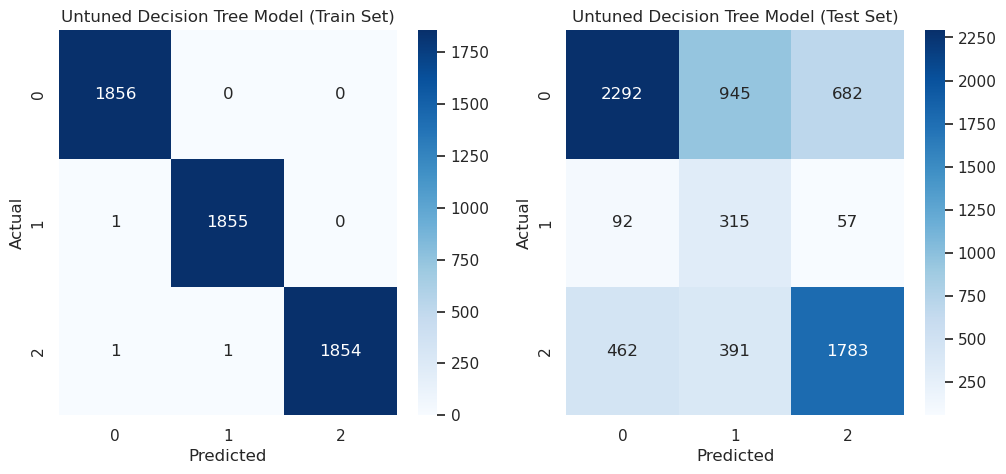

In [48]:
# Confusion matrices for Decision Tree Classifier in prediciting for both train and test sets
cm_train = confusion_matrix(y_train_balanced, y_pred_dt_train)
cm_test = confusion_matrix(y_test_enc, y_pred_dt_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Untuned Decision Tree Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Untuned Decision Tree Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion_matrices-untuned-decision-tree-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

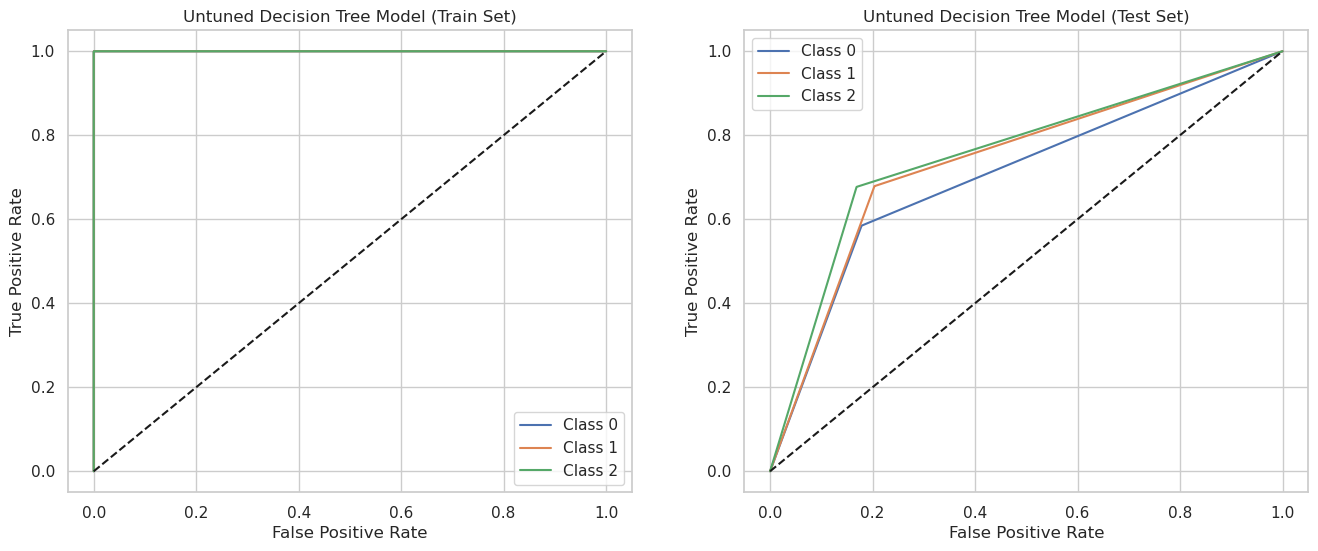

In [49]:
# ROC Curves for Untuned Decision Tree Classifier in predicitng both train and test sets
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y_train_balanced))
y_train_bin = label_binarize(y_train_balanced, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves for untuned Decision Tree Classifier on Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Untuned Decision Tree Model (Train Set)')
axes[0].legend()

# ROC Curves for Untuned Decision Tree Classifier on Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Untuned Decision Tree Model (Test Set)')
axes[1].legend()

plt.savefig("./images/roc-curves-untuned-decision-tree-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

#### 3.2.2 Tuned Decision Tree Classifier

In [50]:
# Hyperparameter tuning for Decision Tree Classifier
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, criterion='gini'), param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1)
gs_dt.fit(X_train_balanced, y_train_balanced)
print(f"Best Decision Tree params: {gs_dt.best_params_}")

Best Decision Tree params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [51]:
# Predict on train and test sets
y_pred_dt_gs_train = gs_dt.predict(X_train_balanced)
y_proba_dt_gs_train = gs_dt.predict_proba(X_train_balanced)
y_pred_dt_gs = gs_dt.predict(X_test_final)
y_proba_dt_gs = gs_dt.predict_proba(X_test_final)

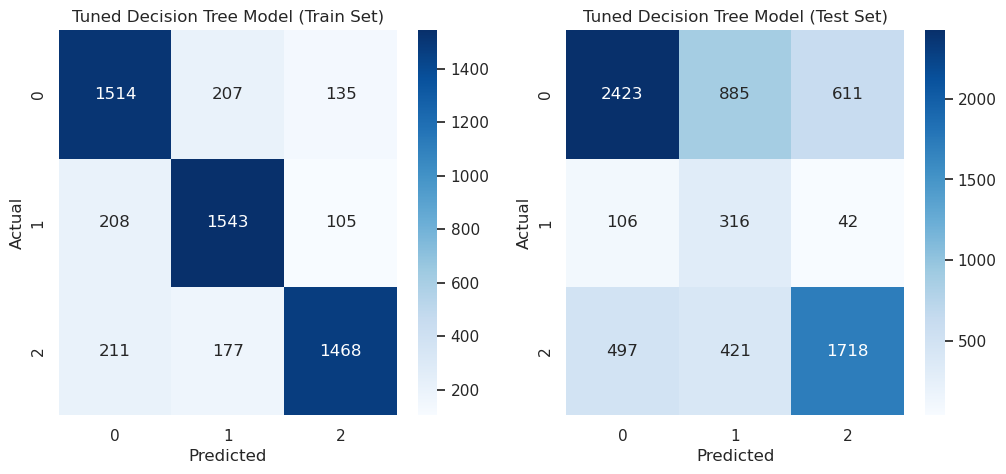

In [52]:
# Confusion matrices for Tuned Decision Tree Classifier in prediciting for both train and test sets
cm_train = confusion_matrix(y_train_balanced, y_pred_dt_gs_train)
cm_test = confusion_matrix(y_test_enc, y_pred_dt_gs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Tuned Decision Tree Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Tuned Decision Tree Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion_matrices-tuned-decision-tree-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

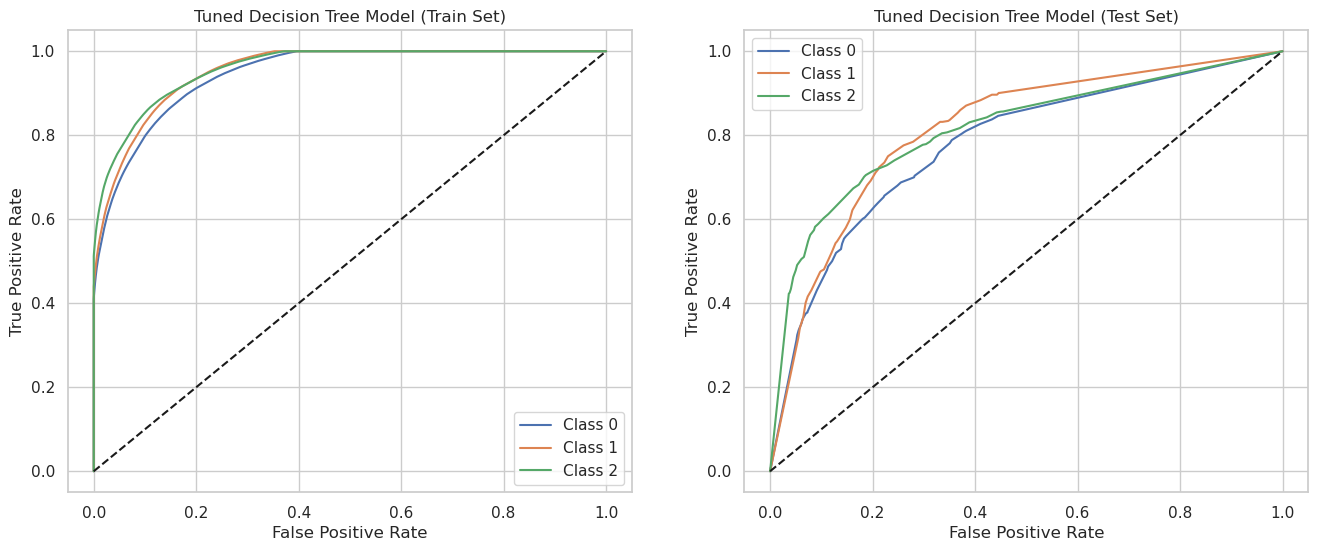

In [53]:
# ROC Curves for Tuned Decision Tree Classifier in predicitng both train and test sets
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y_train_balanced))
y_train_bin = label_binarize(y_train_balanced, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves for untuned Decision Tree Classifier on Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_gs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tuned Decision Tree Model (Train Set)')
axes[0].legend()

# ROC Curves for Untuned Decision Tree Classifier on Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Tuned Decision Tree Model (Test Set)')
axes[1].legend()

plt.savefig("./images/roc-curves-tuned-decision-tree-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [54]:
# Compute metrics for Untuned Decision Tree Classifier
acc_dt_train = accuracy_score(y_train_balanced, y_pred_dt_train)
prec_dt_train = precision_score(y_train_balanced, y_pred_dt_train, average='weighted')
rec_dt_train = recall_score(y_train_balanced, y_pred_dt_train, average='weighted')
f1_dt_train = f1_score(y_train_balanced, y_pred_dt_train, average='weighted')
roc_auc_dt_train = roc_auc_score(y_train_balanced, y_proba_dt_train, multi_class='ovr')

acc_dt_test = accuracy_score(y_test_enc, y_pred_dt_test)
prec_dt_test = precision_score(y_test_enc, y_pred_dt_test, average='weighted')
rec_dt_test = recall_score(y_test_enc, y_pred_dt_test, average='weighted')
f1_dt_test = f1_score(y_test_enc, y_pred_dt_test, average='weighted')
roc_auc_dt_test = roc_auc_score(y_test_enc, y_proba_dt_test, multi_class='ovr')

# Compute metrics for Tuned Decision Tree Classifier
acc_dt_gs_train = accuracy_score(y_train_balanced, y_pred_dt_gs_train)
prec_dt_gs_train = precision_score(y_train_balanced, y_pred_dt_gs_train, average='weighted')
rec_dt_gs_train = recall_score(y_train_balanced, y_pred_dt_gs_train, average='weighted')
f1_dt_gs_train = f1_score(y_train_balanced, y_pred_dt_gs_train, average='weighted')
roc_auc_dt_gs_train = roc_auc_score(y_train_balanced, y_proba_dt_gs_train, multi_class='ovr')

acc_dt_gs_test = accuracy_score(y_test_enc, y_pred_dt_gs)
prec_dt_gs_test = precision_score(y_test_enc, y_pred_dt_gs, average='weighted')
rec_dt_gs_test = recall_score(y_test_enc, y_pred_dt_gs, average='weighted')
f1_dt_gs_test = f1_score(y_test_enc, y_pred_dt_gs, average='weighted')
roc_auc_dt_gs_test = roc_auc_score(y_test_enc, y_proba_dt_gs, multi_class='ovr')

# Create DataFrame with metrics
dt_metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_dt_train, acc_dt_gs_train],
    'Test Accuracy': [acc_dt_test, acc_dt_gs_test],
    'Train Precision': [prec_dt_train, prec_dt_gs_train],
    'Test Precision': [prec_dt_test, prec_dt_gs_test],
    'Train Recall': [rec_dt_train, rec_dt_gs_train],
    'Test Recall': [rec_dt_test, rec_dt_gs_test],
    'Train F1-score': [f1_dt_train, f1_dt_gs_train],
    'Test F1-score': [f1_dt_test, f1_dt_gs_test],
    'Train ROC-AUC': [roc_auc_dt_train, roc_auc_dt_gs_train],
    'Test ROC-AUC': [roc_auc_dt_test, roc_auc_dt_gs_test]
})

# Set the index to 'Model'
dt_metrics_df.set_index('Model', inplace=True)

dt_metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.999461,0.625445,0.999462,0.727775,0.999461,0.625445,0.999461,0.657666,1.000000,0.731613
Tuned Model,0.812680,0.634991,0.814483,0.732079,0.812680,0.634991,0.812901,0.667340,0.953505,0.801969


#### 3.2.3 Model Performance Interpretation: Untuned vs. Tuned Decision Tree

- The untuned Decision Tree classifier achieves an F1-score of 1.0 on the training set and approximately 0.65 on the test set. The model's accuracy is 100% on the training set and around 81% (test).The ROC-AUC score (train) is 1.0 (train) and about 0.73 (test). These performance metrics are supported by the ROC curves in justifying that the untuned Decision Tree Classifier is overfitting the training data.
- After hyperparameter tuning, the Decision Tree's F1-score (train) drops to around 0.82 (train) and 0.67 (test). The tuned model's accuracy is approprimately 81% on the training set and about 63% on the test set. The ROC-AUC score drops to 0.95 (train) but improves to 0.80 on the test set. These slight improvements on the test set metrics and decline on the training set indicates the tuned model's better class discrimination and generalizability. 
- However, both the untuned and the tuned Decision Tree classifier modeles show a substantial gap between training and test performance metrics. This disparity alludes to potential overfitting.


**Limitations:** Decision Trees can easily overfit the training data, especially with many features or when the tree is deep, leading to poor generalization. Small changes in the data can result in very different tree structures, making the model less robust. Additionally, a single tree classifier is limited in capturing complex, non-linear relationships as effectively as ensemble methods. Thus, building a Gradient Boosting Classifier is necessary to achieve higher accuracy, better generalization, and improved performance on all classes in this ternary classification problem.

### 3.3 Ensemble-Based Classification Model

A Gradient Boosting Classifiers fits a number of randomized decision trees on various sub-samples of the training dataset and uses averaging to improve the predictive accuracy and control over-fitting. A Gradient Boosting Classifier is an ensemble method since the modelled decision trees are build sequentially. Each new tree in the sequence is trained to correct the errors made by the sum of previously built trees. Such an iterative error-correction process gradually improves the model's overall performance, reduces bias and minimizes variance across the model's predictions. Thus, building a Gradient Boosting Classifier is necessary since ensemble models:
- Reduce overfitting by combining multiple trees and using regularization.
- Improve predictive accuracy, especially for complex, non-linear relationships.
- Handle class imbalance and minority class prediction better through boosting.
- Are more robust and stable than a single decision tree.


#### 3.3.1 Untuned Gradient Boosting Classifier

In [55]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting on balanced data
gb_bal = GradientBoostingClassifier(random_state=42)
gb_bal.fit(X_train_balanced, y_train_balanced)

GradientBoostingClassifier(random_state=42)

In [56]:
# Predict on train and test sets
y_pred_gb_train = gb_bal.predict(X_train_balanced)
y_proba_gb_train = gb_bal.predict_proba(X_train_balanced)
y_pred_gb_test = gb_bal.predict(X_test_final)
y_proba_gb_test = gb_bal.predict_proba(X_test_final)

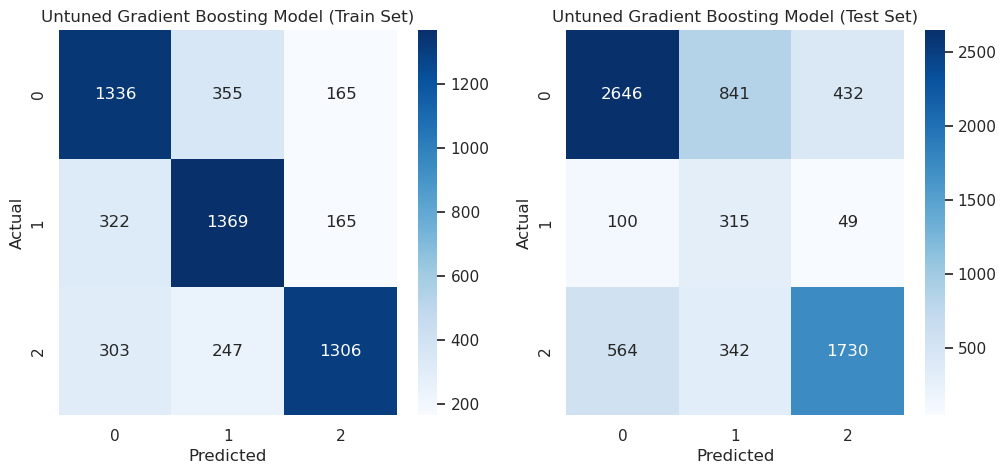

In [57]:
# Plot confusion matrices for Gradient Boosting Classifier on both train and test sets
cm_gb_train = confusion_matrix(y_train_balanced, y_pred_gb_train)
cm_gb_test = confusion_matrix(y_test_enc, y_pred_gb_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set confusion matrix
sns.heatmap(cm_gb_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Untuned Gradient Boosting Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test set confusion matrix
sns.heatmap(cm_gb_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Untuned Gradient Boosting Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-untuned-gradient-boosting-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

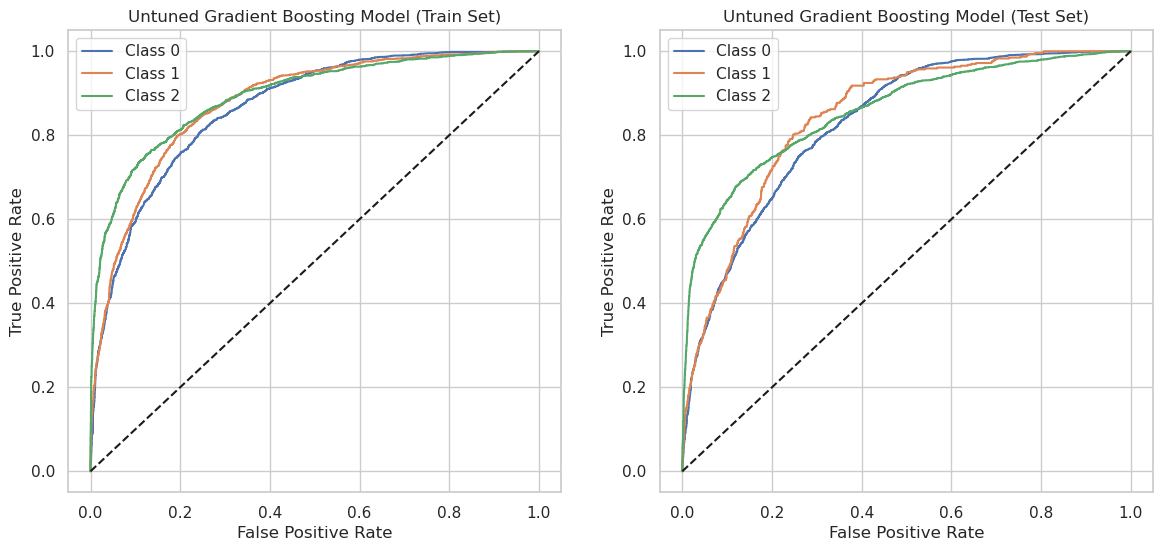

In [58]:
# Binarize the true labels for multiclass ROC
n_classes = len(np.unique(y_train_balanced))
y_train_bin = label_binarize(y_train_balanced, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# ROC curves for train set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gb_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Untuned Gradient Boosting Model (Train Set)')
axes[0].legend()
axes[0].grid(True)

# ROC curves for test set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Untuned Gradient Boosting Model (Test Set)')
axes[1].legend()
axes[1].grid(True)

plt.savefig("./images/roc-curves-untuned-gradient-boosting-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [59]:
#Define parameter grid for tuning the Gradient Boosting Classifier
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize GridSearchCV
gs_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on balanced training data
gs_gb.fit(X_train_balanced, y_train_balanced)
print(f"Best Gradient Boosting params: {gs_gb.best_params_}")

Best Gradient Boosting params: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200, 'subsample': 1.0}


In [60]:
# Predict on train and test sets
y_pred_gb_rs_train = gs_gb.predict(X_train_balanced)
y_proba_gb_rs_train = gs_gb.predict_proba(X_train_balanced)
y_pred_gb_rs = gs_gb.predict(X_test_final)
y_proba_gb_rs = gs_gb.predict_proba(X_test_final)

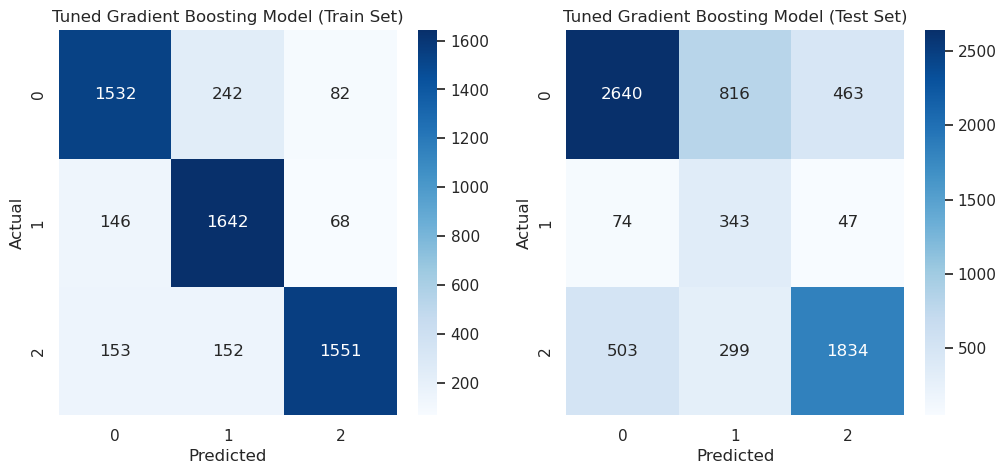

In [61]:
# Confusion matrices for Tuned Gradient Boosting Classifier in predicting for both train and test sets
cm_train_gb_rs = confusion_matrix(y_train_balanced, y_pred_gb_rs_train)
cm_test_gb_rs = confusion_matrix(y_test_enc, y_pred_gb_rs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Train Set
sns.heatmap(cm_train_gb_rs, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Tuned Gradient Boosting Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot for Test Set
sns.heatmap(cm_test_gb_rs, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Tuned Gradient Boosting Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-tuned-gradient-boosting-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

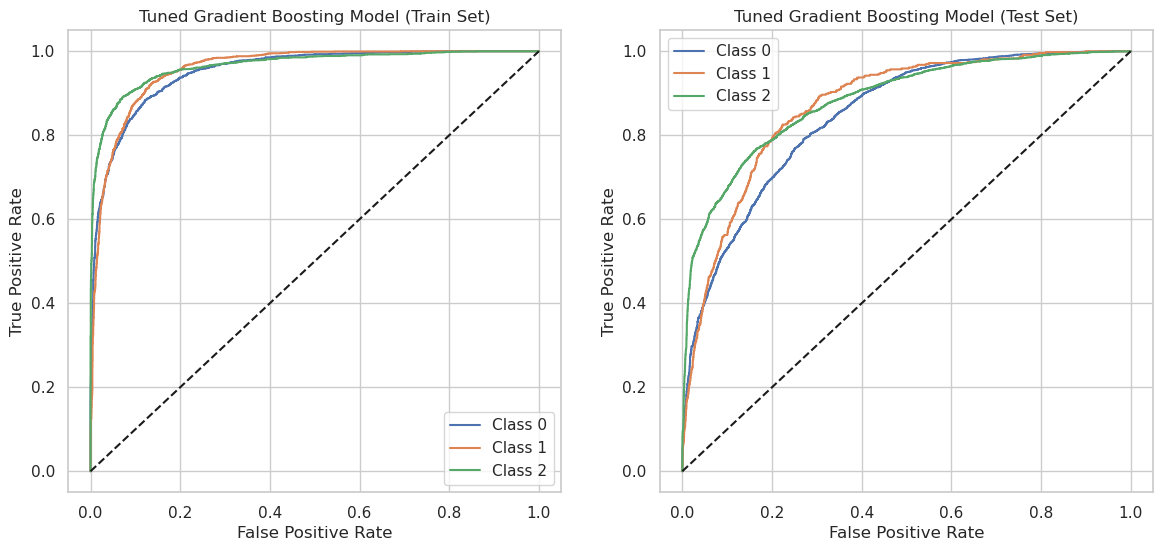

In [62]:
# Plot ROC curves for the tuned Gradient Boosting model on both train and test sets, side by side
n_classes = len(np.unique(y_train_balanced))
y_train_bin = label_binarize(y_train_balanced, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# ROC curves for train set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gb_rs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tuned Gradient Boosting Model (Train Set)')
axes[0].legend()
axes[0].grid(True)

# ROC curves for test set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb_rs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Tuned Gradient Boosting Model (Test Set)')
axes[1].legend()
axes[1].grid(True)

plt.savefig("./images/roc-curves-tuned-gradient-boosting-classifier.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [63]:
# Compute performance metrics for untuned Gradient Boosting Classifier
acc_gb_train = accuracy_score(y_train_balanced, y_pred_gb_train)
prec_gb_train = precision_score(y_train_balanced, y_pred_gb_train, average='weighted')
rec_gb_train = recall_score(y_train_balanced, y_pred_gb_train, average='weighted')
f1_gb_train = f1_score(y_train_balanced, y_pred_gb_train, average='weighted')
roc_auc_gb_train = roc_auc_score(y_train_balanced, y_proba_gb_train, multi_class='ovr')

acc_gb_test = accuracy_score(y_test_enc, y_pred_gb_test)
prec_gb_test = precision_score(y_test_enc, y_pred_gb_test, average='weighted')
rec_gb_test = recall_score(y_test_enc, y_pred_gb_test, average='weighted')
f1_gb_test = f1_score(y_test_enc, y_pred_gb_test, average='weighted')
roc_auc_gb_test = roc_auc_score(y_test_enc, y_proba_gb_test, multi_class='ovr')

# Compute performance metrics for tuned Gradient Boosting Classifier
acc_gb_rs_train = accuracy_score(y_train_balanced, y_pred_gb_rs_train)
prec_gb_rs_train = precision_score(y_train_balanced, y_pred_gb_rs_train, average='weighted')
rec_gb_rs_train = recall_score(y_train_balanced, y_pred_gb_rs_train, average='weighted')
f1_gb_rs_train = f1_score(y_train_balanced, y_pred_gb_rs_train, average='weighted')
roc_auc_gb_rs_train = roc_auc_score(y_train_balanced, y_proba_gb_rs_train, multi_class='ovr')

acc_gb_rs_test = accuracy_score(y_test_enc, y_pred_gb_rs)
prec_gb_rs_test = precision_score(y_test_enc, y_pred_gb_rs, average='weighted')
rec_gb_rs_test = recall_score(y_test_enc, y_pred_gb_rs, average='weighted')
f1_gb_rs_test = f1_score(y_test_enc, y_pred_gb_rs, average='weighted')
roc_auc_gb_rs_test = roc_auc_score(y_test_enc, y_proba_gb_rs, multi_class='ovr')

# Create DataFrame with metrics
gb_metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_gb_train, acc_gb_rs_train],
    'Test Accuracy': [acc_gb_test, acc_gb_rs_test],
    'Train Precision': [prec_gb_train, prec_gb_rs_train],
    'Test Precision': [prec_gb_test, prec_gb_rs_test],
    'Train Recall': [rec_gb_train, rec_gb_rs_train],
    'Test Recall': [rec_gb_test, rec_gb_rs_test],
    'Train F1-score': [f1_gb_train, f1_gb_rs_train],
    'Test F1-score': [f1_gb_test, f1_gb_rs_test],
    'Train ROC-AUC': [roc_auc_gb_train, roc_auc_gb_rs_train],
    'Test ROC-AUC': [roc_auc_gb_test, roc_auc_gb_rs_test]
})

# Set the index to 'Model'
gb_metrics_df.set_index('Model', inplace=True)

gb_metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.720366,0.668329,0.724715,0.754088,0.720366,0.668329,0.721155,0.698047,0.879053,0.843328
Tuned Model,0.848599,0.686280,0.851667,0.767590,0.848599,0.686280,0.848964,0.713329,0.958991,0.866277


#### 3.3.3 Model Performance Interpretation: Untuned vs. Tuned Gradient Boosting Classifier

The tuned Gradient Boosting Classifier outperforms the untuned version across all metrics on both the training and test sets.

- **F1-score:** Untuned model achieves approximately 0.72 (train) and 0.70 (test), while the tuned model improves to 0.84 (train) and 0.71 (test), indicating better balance between precision and recall after tuning.

- **Accuracy:** Untuned model achieves an accuracy score of about 72% on the training set and 67% on (test). For the tuned classifier; the accuracy improves to around 85% (train) and 69% (test).

- **Precision & Recall:** Both metrics are higher for the tuned model, showing improved ability to correctly identify all classes.
- **ROC-AUC:** Tuned model achieves a score of approximately 0.96 (train) and 0.87 (test), compared to 0.89 (train) and 0.84 (test) for the untuned model.

The consistent improvements of the tuned Gradient Boosting Classifier justifies its superiority in comparison to the other models. Additionally, the lesser variation between its scores on (train) and (test) confirm that the model is not overfitting the training set. 

## 4 Best Supervised ML Classifier

### 4.1 Select Deployment Model
This section compares the respective performance metrics (Accuracy, Precision, Recall, F1-score, and ROC-AUC) for all models (untuned and tuned). The insights deduced from these comparisons are vital in supporting data-driven decisions on the best-fit/ most-appropriate supervised ML classifier for deployment. The best model based on performance metrics and generalizability insights is selected for deployment for utilization in predicting the functional status of a Tanzanian water well. Highly accurate predictions are crucial in optimizing the operational effectiveness of NGO's focused on locating wells in need of maintenance/ repairs. Additionally, a generalizable model will support the Tanzanian Government in extrapolating patterns for non-functional wells to make better-informed, data-supported decisions on the framework for designing, planning, and implementing new ground water infrustructure. 

In [64]:
# Compare the performance for all the models (tuned and untuned classifiers)
all_metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression (Untuned)', 
              'Logistic Regression (Tuned)', 
              'Decision Tree (Untuned)', 
              'Decision Tree (Tuned)', 
              'Gradient Boosting (Untuned)', 
              'Gradient Boosting (Tuned)'],
    'Train Accuracy': [acc_train, acc_gs_train, acc_dt_train, acc_dt_gs_train, acc_gb_train, acc_gb_rs_train],
    'Test Accuracy': [acc_test, acc_gs, acc_dt_test, acc_dt_gs_test, acc_gb_test, acc_gb_rs_test],
    'Train Precision': [prec_train, prec_gs_train, prec_dt_train, prec_dt_gs_train, prec_gb_train, prec_gb_rs_train],
    'Test Precision': [prec_test, prec_gs, prec_dt_test, prec_dt_gs_test, prec_gb_test, prec_gb_rs_test],
    'Train Recall': [rec_train, rec_gs_train, rec_dt_train, rec_dt_gs_train, rec_gb_train, rec_gb_rs_train],
    'Test Recall': [rec_test, rec_gs, rec_dt_test, rec_dt_gs_test, rec_gb_test, acc_gb_rs_test],
    'Train F1-score': [f1_train, f1_gs_train, f1_dt_train, f1_dt_gs_train, f1_gb_train, f1_gb_rs_train],
    'Test F1-score': [f1_test, f1_gs, f1_dt_test, f1_dt_gs_test, f1_gb_test, f1_gb_rs_test],
    'Train ROC-AUC': [roc_auc_train, roc_auc_gs_train, roc_auc_dt_train, roc_auc_dt_gs_train, roc_auc_gb_train, roc_auc_gb_rs_train],
    'Test ROC-AUC': [roc_auc_test, roc_auc_gs, roc_auc_dt_test, roc_auc_dt_gs_test, roc_auc_gb_test, roc_auc_gb_rs_test]
})

# Calculate cumulative score across all metrics for each model
all_metrics_df

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression (Untuned),0.649425,0.640120,0.653538,0.735050,0.649425,0.640120,0.650206,0.674341,0.831456,0.816311
1,Logistic Regression (Tuned),0.650503,0.636843,0.654797,0.734322,0.650503,0.636843,0.651274,0.671957,0.832015,0.816505
2,Decision Tree (Untuned),0.999461,0.625445,0.999462,0.727775,0.999461,0.625445,0.999461,0.657666,1.000000,0.731613
3,Decision Tree (Tuned),0.812680,0.634991,0.814483,0.732079,0.812680,0.634991,0.812901,0.667340,0.953505,0.801969
4,Gradient Boosting (Untuned),0.720366,0.668329,0.724715,0.754088,0.720366,0.668329,0.721155,0.698047,0.879053,0.843328
5,Gradient Boosting (Tuned),0.848599,0.686280,0.851667,0.767590,0.848599,0.686280,0.848964,0.713329,0.958991,0.866277


- **Logistic Regression**: Both untuned and tuned versions perform similarly, with the tuned model showing slight improvements across all metrics. However, the overall F1-score and accuracy are moderate, indicating limited ability to capture complex patterns in the data.

- **Decision Tree**: The untuned Decision Tree exhibits lower test set performance and a notable gap between train and test metrics, suggesting overfitting. Tuning improves generalization slightly, but both versions lag behind Logistic Regression and Gradient Boosting, especially in F1-score and ROC-AUC.

- **Gradient Boosting**: Both untuned and tuned Gradient Boosting Classifiers outperform the other models across all metrics. The model achieves the highest F1-score (0.84 train, 0.71 test), accuracy (0.84 train, 0.69 test), and ROC-AUC (0.96 train, 0.87 test). The relatively smaller gap between train and test performance metrics results, justifies the good generalizability and robustness of the tuned Gradient Boosting Classifier.

**Selected Model:** Based on the evaluation, the tuned Gradient Boosting Classifier is the best choice for deployment. It consistently delivers superior predictive performance, balances precision and recall across all classes, and demonstrates strong generalization to unseen data. Additionally, the gap between train and test performance remains small, suggesting the tuned model generalizes well and does not overfit. Hyperparameter tuning the Gradient Boosting Classifiers results in a robust, accurate, and highly generalizable supervised ML model, making the tuned Gradient Boosting Classifier the best performer among all models evaluated. Thus,the **tuned Gradient Boosting Classifier** is the most reliable, effective, and best-choice model for deployment to predict the status of water wells in Tanzania.

### 4.2 Feature Importance


The Numerical features included in the training dataset are normalized using the MinMaXScaller to ensure their values range from 0 to 1. The Categorical features included in the training dataset are OneHotEncoded whereby the values for the dummy variables are either 0 or 1. The target variable is also encoded whereby its three classes are assigned either 0, 1, or 2. Since all the variables in the balanced training set utilized to train the models are numerical, the f_classif (ANOVA F-value) metric is computed access the statistical difference in the means of each feature across the three different classes of the target variables. 
- A higher f_classif stastic for an OHE column suggests that the presence or absence of that specific dummy variable is associated with the different target classes and vice-versa. 
- A higher f_statistic for a normalized numerical feature implies that the values of the independent variable are meaningly different across the various classes of the target variable and vice-versa.  


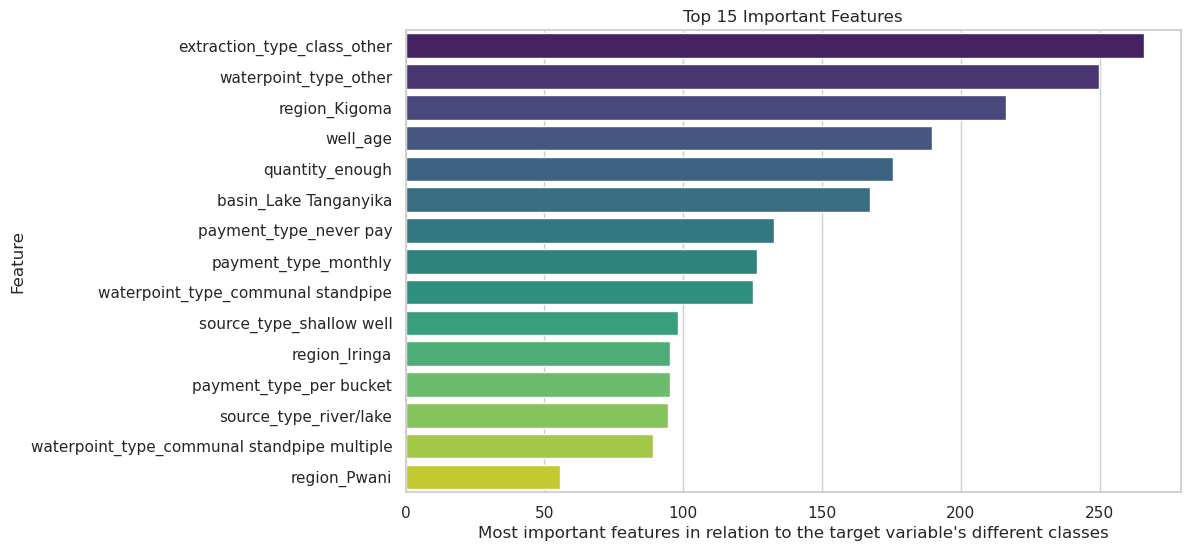

In [65]:
from sklearn.feature_selection import SelectKBest, f_classif
feature_names = X_train_balanced.columns.tolist()
scores, pvalues = f_classif(X_train_balanced, y_train_balanced)

feature_scores_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort by Score in descending order and select top 15 features
top_features = feature_scores_df.sort_values(by='Score', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
plt.xlabel("Most important features in relation to the target variable's different classes")
plt.ylabel('Feature')
plt.title('Top 15 Important Features')

# Save plot to images folder
plt.savefig("./images/top-15-important-features.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

Per the top-15-important-features plot; it is evident that `water_point_type_group`, `extraction_type_class`, `well_age`, `quantity`, `payment_type`, `region`, `source_type`, `basin`, and `water_quality` features are significant predictor features for a water well's functional status. Thus, the preprocessed train set is clean, appropriately balanced. and adequately inclusive of the most important features, for predicting the target variable.

## 5 Model Validation

In [66]:
# Load test dataset
test_features = pd.read_csv('./data/testdata.csv')

# Display first five rows of the test set
test_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [67]:
test_features.shape

(14850, 40)

In [68]:
# Preprocess the evaluation dataset features per the preprocessing pipeline

# Create a copy of the test features DataFrame
evaluation_df = test_features.copy()

# 1. Drop irrelevant columns
evaluation_df = evaluation_df.loc[:, picked_cols]

# 2. Engineer the `well_age` feature and drop entries whose `well_age` is less than 0
evaluation_df['date_recorded'] = pd.to_datetime(evaluation_df['date_recorded']).dt.year
evaluation_df['well_age'] = evaluation_df['date_recorded'] - evaluation_df['construction_year']
evaluation_df = evaluation_df.drop(columns=['construction_year', 'date_recorded'])

# 3. Identify numerical and categorical features
evaluation_num_cols = evaluation_df.select_dtypes(include=[np.number]).columns.tolist()
evaluation_cat_cols = evaluation_df.select_dtypes(include=['object']).columns.tolist()

# 4. Normalize numerical features
evaluation_scaled = evaluation_df.copy()
evaluation_scaled[evaluation_num_cols] = scaler.transform(evaluation_scaled[evaluation_num_cols])
evaluation_num_df = pd.DataFrame(evaluation_scaled, columns=evaluation_num_cols, index=evaluation_scaled.index)

# 5. One-hot encode categorical features
test_cat_features = ohe.transform(evaluation_scaled[evaluation_cat_cols])
test_cat_feature_names = ohe.get_feature_names_out(evaluation_cat_cols)
evaluation_ohe_df = pd.DataFrame(test_cat_features, columns=test_cat_feature_names, index=evaluation_scaled.index)

# 6. Concat normalized numerical features and OneHot encoded cataegorical features
evaluation_df_final = pd.concat([evaluation_num_df, evaluation_ohe_df], axis=1)

# Check model valuation dataset shape
evaluation_df_final.shape
print(f"Evaluation dataset consists of: {evaluation_df_final.shape[0]} rows")
print(f"Evaluation dataset consists of: {evaluation_df_final.shape[1]} columns")

# Display the preprocessed test set
evaluation_df_final.head()

Evaluation dataset consists of: 14850 rows
Evaluation dataset consists of: 67 columns


,gps_height,population,well_age,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,0.917839,0.1284,0.022727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.724013,0.1200,0.295455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.723105,0.2000,0.068182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.133000,0.1000,0.590909,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.583749,0.0240,0.295455,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


- Predict the `status_group` of entries in the testdata.csv dataset using the **Tuned Gradient Boosting Classifier** and format the results for submission as specified in SubmissionFormat.csv.

In [69]:
# Predict the status_group for the test set
test_predictions = gs_gb.predict(evaluation_df_final)

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': test_features['id'],
    'status_group': le.inverse_transform(test_predictions)
})

submission_df.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional needs repair


In [70]:
# Check shape
submission_df.shape

(14850, 2)

In [71]:
# Save the submission DataFrame to a CSV file
submission_df.to_csv('./data/final-submission.csv', index=False)

## 6 Conclusion, Recommendations, and Next Steps

### 6.1 Conclusion

The analysis of the Tanzanian water-wells' dataset demonstrates that supervised machine learning models can effectively predict the functional status of water wells using historical and engineered features. The hyperparameter-tuned Gradient Boosting Classifier consistently outperformed both Logistic Regression and Decision Tree models across all performance metrics on the test set. 

Additionally, the tuned Gradient Boosting Classifier was consistent across all performance metrics (achieved the smallest variance for scores between the training set and the test). Additionally, the confusion matrices and ROC curves for the model justified its relatively stronger predictive power and robustness in generalizing to unseen data. These findings are backed up by its scores in the ROC-AUC metric, which solidified the model's superiority in distinguishing between the three water-well functional-status classes (**functional**, **non-functional**, **functional need repair**).

Therefore, this project confirms that with appropriate preprocessing, feature engineering, and model selection, machine learning can provide actionable insights for water well maintenance and resource allocation. The tuned Gradient Boosting Classifier is recommended for deployment due to its superior accuracy, balanced performance across all classes, and robustness against overfitting. The model was validated by calling it to predict the `status_group` values for 14,850 entries from a previously unseen dataset (**testdata.csv**). 

### 6.2 Recommendations
The feature importance plot highlights that `water_point_type_group`, `extraction_type_class`, and `well_age` as the most influential predictors for a water-well's functional status. Other significant features include `quantity`, `payment_type`, `region`, `source_type`, `basin`, and `water_quality`.

The `well_age` feature, which captures the difference between the year the well was recorded and its construction year, proved to be a critical factor (older wells are more likely to be non-functional or in need of repair). The type of water point and extraction method also play a substantial role, indicating that certain technologies or infrastructure types are more prone to failure. Regional and environmental factors, such as the well's location (`region`, `basin`) and `water_quality`, further influence the likelihood of a well being functional.

Based on these findings, it is recommended that maintenance and resource allocation efforts prioritize wells that are older, utilize less reliable extraction types, or are located in regions with historically higher rates of non-functionality. Monitoring and proactive intervention for these high-risk wells can help improve water access and reduce downtime. Additionally, the importance of payment and management types suggests that community engagement and sustainable management practices may also contribute to better well functionality outcomes.

These insights provide actionable guidance for stakeholders aiming to optimize well maintenance schedules and target interventions where they are most needed, ultimately supporting more reliable access to clean water in Tanzania.

### 6.3 Next Steps

1. **Model Deployment**: Integrate the recommended **Tuned Gradient Boosting Classifier** model into a user-friendly dashboard for real-time predictions.

2. **Integrate Model Predictions into Maintenance Planning**: Use the model’s predictions to inform and optimize maintenance schedules, prioritizing wells identified as high-risk based on key features such as well age, extraction type, and water point type group.

3. **Pilot Targeted Interventions**: Use the model to pilot targeted maintenance or resource allocation interventions in regions or for well types identified as high-risk, and measure the impact on well functionality and service delivery.

4. **Collect and Incorporate Additional Data**: Encourage field teams to collect more granular data on well management, payment types, and environmental factors. Additional features may further improve model performance and provide deeper insights. As new data becomes available, retrain and validate the model to ensure its continued accuracy and relevance. This will help adapt to changing patterns in well functionality and environmental conditions.

